<a href="https://colab.research.google.com/github/Kranium2002/Art-Generation-with-Neural-Style-Transfer/blob/main/Leaf_Classification_Hybrid_Model_Resnet%2BXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Khushiyant/crop-guard.git

Cloning into 'crop-guard'...
fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
!git clone https://github.com/gabrieldgf4/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 54511, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 54511 (delta 36), reused 0 (delta 0), pack-reused 54403
Receiving objects: 100% (54511/54511), 806.27 MiB | 37.61 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Checking out files: 100% (54306/54306), done.


In [ ]:
!git clone https://github.com/Kranium2002/Bark_Classification.git

Cloning into 'Bark_Classification'...
remote: Enumerating objects: 5654, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 5654 (delta 15), reused 15 (delta 4), pack-reused 5621
Receiving objects: 100% (5654/5654), 259.04 MiB | 36.43 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Checking out files: 100% (5581/5581), done.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard

from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tqdm import tqdm
import cv2 as cv2
from keras.preprocessing.image import img_to_array

In [2]:
directory_root = '/content/PlantVillage-Dataset'

Data for Resnet Training

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
directory = "/content/PlantVillage-Dataset/"
train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset =tf.keras.utils.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 54305 files belonging to 40 classes.
Using 43444 files for training.
Found 54305 files belonging to 40 classes.
Using 10861 files for validation.


Data for XGBoost Training and Testing of models

In [3]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 64
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    
    zoom_range = 0.2, 
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 180,
    validation_split = 0.3) 

train_generator = data_generator.flow_from_directory(
    
                                            directory_root,
                                            class_mode = 'categorical',
                                             shuffle=True,
                                             batch_size=64,
                                             target_size =IMG_SIZE,
                                             
                                             subset='training',
                                             seed=42)

validation_generator = data_generator.flow_from_directory( 
directory_root,
                                            class_mode = 'categorical',
                                             shuffle=True,
                                             batch_size=64,
                                             target_size =IMG_SIZE,
                                             
                                             subset='validation',
                                             seed=42)

Found 38031 images belonging to 40 classes.
Found 16274 images belonging to 40 classes.


In [4]:
train_generator.reset()
x_train, y_train = next(train_generator)
for i in tqdm(range(int(len(train_generator)/16-1))): #1st batch is already fetched before the for loop.
  img, label = next(train_generator)
  x_train = np.append(x_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|██████████| 36/36 [00:40<00:00,  1.12s/it]

(2368, 256, 256, 3) (2368, 40)


In [5]:
validation_generator.reset()
x_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(validation_generator)/8)-1)): #1st batch is already fetched before the for loop.
  img, label = next(validation_generator)
  x_test = np.append(x_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(x_test.shape, y_test.shape)

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]

(1984, 256, 256, 3) (1984, 40)


In [7]:
del(train_generator)
del(validation_generator)

In [8]:
Y_train=[]
for i in range(y_train.shape[0]):
  temp=y_train[i][0:]
  temp = np.argmax(temp)
  Y_train.append(temp)

Y_train=np.asarray(Y_train)
Y_train.shape  



(2368,)

In [9]:
Y_test=[]
for i in range(y_test.shape[0]):
  temp=y_test[i][0:]
  temp = np.argmax(temp)
  Y_test.append(temp)

Y_test=np.asarray(Y_test)
Y_test.shape  

(4032,)

In [11]:
del(y_train)
del(y_test)

In [10]:
del(temp)

Basic Data Argumentation to increase the generalization of models

In [ ]:

def data_augmenter():

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    
    return data_augmentation

Base Resnet50 Model

In [ ]:
def leaf_model(model_input: Tensor, data_augmentation=data_augmenter()):

    
    
    
    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(256,256,3),
                                                   include_top=False, 
                                                   weights='imagenet',input_tensor=model_input) 
    

    base_model.trainable = False
   
    data_augmentation = data_augmenter()
   
    x = data_augmentation(model_input)
   
    x = tf.keras.applications.resnet50.preprocess_input(x) 
    
   
    x = base_model(x, training=False) 
    
   
   
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
   
    x = tf.keras.layers.Dropout(0.2)(x)
        
   
    x = tf.keras.layers.Dense(50)(x)
    
  
    
    model = Model(model_input, x, name='model')
    
    return model

In [ ]:
input_shape = (256,256,3)
print(input_shape)
model_input = Input(shape=input_shape)
print(model_input)

(256, 256, 3)
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
model = leaf_model(model_input, data_augmenter())

for layer in model.layers:
  print(layer)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:

model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Training Resnet with last layer as a Softmax layer

In [ ]:
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=10)

Epoch 1/10
1358/1358 [==============================] - 254s 176ms/step - loss: 0.3588 - accuracy: 0.9056 - val_loss: 0.1490 - val_accuracy: 0.9538
Epoch 2/10
1358/1358 [==============================] - 243s 179ms/step - loss: 0.1257 - accuracy: 0.9614 - val_loss: 0.1232 - val_accuracy: 0.9595
Epoch 3/10
1358/1358 [==============================] - 244s 179ms/step - loss: 0.0985 - accuracy: 0.9689 - val_loss: 0.1357 - val_accuracy: 0.9611
Epoch 4/10
1358/1358 [==============================] - 243s 179ms/step - loss: 0.0895 - accuracy: 0.9710 - val_loss: 0.0954 - val_accuracy: 0.9688
Epoch 5/10
1358/1358 [==============================] - 244s 179ms/step - loss: 0.0808 - accuracy: 0.9731 - val_loss: 0.1039 - val_accuracy: 0.9684
Epoch 6/10
1358/1358 [==============================] - 243s 179ms/step - loss: 0.0749 - accuracy: 0.9754 - val_loss: 0.0955 - val_accuracy: 0.9693
Epoch 7/10
1358/1358 [==============================] - 243s 179ms/step - loss: 0.0754 - accuracy: 0.9748 - val_

In [12]:
del(train_dataset)
del(validation_dataset)

Result of Transfer Training with Resnet50


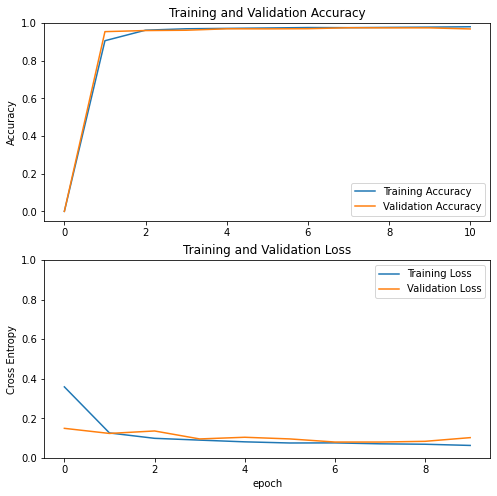

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#For training 

model.save('model.h5')

In [12]:
#For training 


model = tf.keras.models.load_model('/content/model.h5')

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [11]:
pred = model.predict(x_test)

In [12]:
y_test.shape

(4032, 40)

In [13]:
Pred=[]
for i in range(pred.shape[0]):
  temp=pred[i][0:]
  temp = np.argmax(temp)
  Pred.append(temp)
Pred=np.asarray(Pred)
Pred.shape  

(4032,)

In [14]:
Pred[0]

6

In [15]:
from sklearn.metrics import r2_score

Only Resnet R2 score

In [16]:
r2_score(Y_test, Pred)

0.6322620495494758

In [18]:
del(pred)
del(Pred)

NameError: ignored

Making an intermediate layer model from resnet to use for feature selection 

In [13]:
from keras.models import Model
layer_name='global_average_pooling2d'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [14]:
#Deleting base model for memory optimization

del(model)


In [15]:
import pandas as pd

In [16]:

intermediate_output = intermediate_layer_model.predict(x_test) 
intermediate_output = pd.DataFrame(data=intermediate_output)

In [17]:
intermediate_output.shape

(4032, 2048)

In [ ]:

intermediate_output_train = intermediate_layer_model.predict(x_train) 
intermediate_output_train = pd.DataFrame(data=intermediate_output_train)

In [17]:
#Reset GPU for memory optimization

!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
intermediate_output_train.shape

(2368, 2048)

(1152,)

In [19]:
del(intermediate_layer_model)


Starting to make hybrid models using XGBoost

In [20]:
from xgboost import XGBClassifier

In [21]:


xgbmodel = XGBClassifier(objective='multi:softprob', 
                      num_class= 50)


Results of Conv XGBoost hybrid model

In [22]:

xgb = XGBClassifier(objective='multi:softprob', 
                      num_class= 50)

In [23]:
xgb.fit(intermediate_output_train,Y_train)

XGBClassifier(num_class=50, objective='multi:softprob')

R2 Score of Hybrid classifier

In [24]:
xgb.score(intermediate_output, Y_test)

0.8659274193548387